In [ ]:
!pip install diffusers==0.14.0 transformers xformers git+https://github.com/huggingface/accelerate.git

In [2]:
from diffusers.utils import load_image 
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, EulerAncestralDiscreteScheduler
from PIL import Image 
from typing import Tuple, List
import re
import ast
import numpy as np 
import cv2
import math
import matplotlib.pyplot as plt 
import torch


%matplotlib inline

In [3]:
def extract_data(gpt_answer:str):
    # get candidate and subset lists 
    candidate_string = re.search(r'candidate = \[(.*?)\n\]', gpt_answer, re.DOTALL).group(1)
    subset_string = re.search(r'subset = \[(.*?)\n\]', gpt_answer, re.DOTALL).group(1)
    
    # remove code comments if any
    candidate_string = re.sub(r'#.*', '', candidate_string)
    subset_string = re.sub(r'#.*', '', subset_string)
    
    # convert strings to lists
    candidate = ast.literal_eval(f'[{candidate_string.strip()}]')
    subset = ast.literal_eval(f'[{subset_string.strip()}]')
    
    return np.array(candidate), np.array(subset)


def draw_bodypose(canvas, candidate, subset):
    stickwidth = 4
    limbSeq = [[2, 3], [2, 6], [3, 4], [4, 5], [6, 7], [7, 8], [2, 9], [9, 10], \
               [10, 11], [2, 12], [12, 13], [13, 14], [2, 1], [1, 15], [15, 17], \
               [1, 16], [16, 18], [3, 17], [6, 18]]

    colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0], \
              [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], \
              [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]
    for i in range(18):
        for n in range(len(subset)):
            index = int(subset[n][i])
            if index == -1:
                continue
            x, y = candidate[index][0:2]
            cv2.circle(canvas, (int(x), int(y)), 4, colors[i], thickness=-1)
    for i in range(17):
        for n in range(len(subset)):
            index = subset[n][np.array(limbSeq[i]) - 1]
            if -1 in index:
                continue
            cur_canvas = canvas.copy()
            Y = candidate[index.astype(int), 0]
            X = candidate[index.astype(int), 1]
            mX = np.mean(X)
            mY = np.mean(Y)
            length = ((X[0] - X[1]) ** 2 + (Y[0] - Y[1]) ** 2) ** 0.5
            angle = math.degrees(math.atan2(X[0] - X[1], Y[0] - Y[1]))
            polygon = cv2.ellipse2Poly((int(mY), int(mX)), (int(length / 2), stickwidth), int(angle), 0, 360, 1)
            cv2.fillConvexPoly(cur_canvas, polygon, colors[i])
            canvas = cv2.addWeighted(canvas, 0.4, cur_canvas, 0.6, 0)
    return canvas

In [4]:
# get data for the pose image
gpt_answer = """candidate = [
    [256, 200],  # Nose (0)
    [256, 230],  # Neck (1)
    [226, 230],  # Right shoulder (2)
    [206, 280],  # Right elbow (3)
    [226, 330],  # Right wrist (4)
    [286, 230],  # Left shoulder (5)
    [306, 280],  # Left elbow (6)
    [286, 330],  # Left wrist (7)
    [256, 390],  # Right hip (8)
    [266, 430],  # Right knee (9)
    [276, 470],  # Right ankle (10)
    [246, 390],  # Left hip (11)
    [246, 430],  # Left knee (12)
    [236, 470],  # Left ankle (13)
    [246, 190],  # Right eye (14)
    [266, 190],  # Left eye (15)
    [256, 190],  # Right ear (16)
    [266, 190],  # Left ear (17)
]
subset = [
    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
]"""

candidate, subset = extract_data(gpt_answer)
print(f"Candidate: {candidate}")
print(f"Subset: {subset}")

Candidate: [[256 200]
 [256 230]
 [226 230]
 [206 280]
 [226 330]
 [286 230]
 [306 280]
 [286 330]
 [256 390]
 [266 430]
 [276 470]
 [246 390]
 [246 430]
 [236 470]
 [246 190]
 [266 190]
 [256 190]
 [266 190]]
Subset: [[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]]


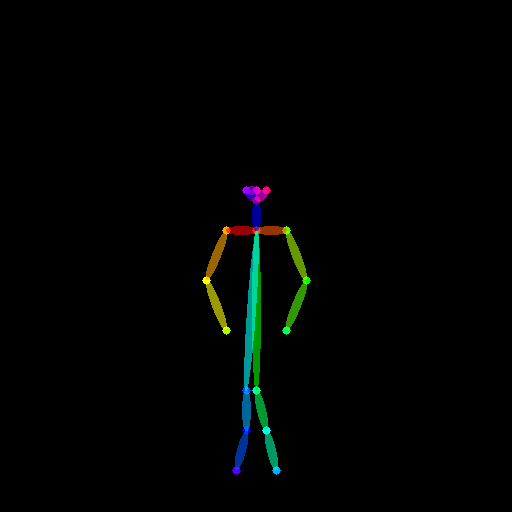

In [5]:
# generate pose image
height, width = 512, 512
canvas = np.zeros((height, width, 3), dtype=np.uint8)
gpt_pose_image = draw_bodypose(canvas, candidate, subset)
gpt_pose_image = Image.fromarray(gpt_pose_image)

gpt_pose_image

In [14]:
# pose image generated by GPT 
gpt_pose_image = gpt_pose_image
# corresponding prompt, also generated by GPT
gpt_prompt = "A high quality photo of a man standing in a bus station. The camera captures his facial expression, showing his boredom. (Camera settings: 85mm lens, f/2.8, ISO 400, 1/250 shutter speed)"
# frame sequence id corresponding to the prompt.
frame_id = 1
save_name = f"frame_{str(frame_id)}.png"

# negative prompt 
negative_prompt = "worst quality, low quality"

In [7]:
CONTROLNET_MODEL = "fusing/stable-diffusion-v1-5-controlnet-openpose"
SD_MODEL = "runwayml/stable-diffusion-v1-5"

In [8]:
# load and create sd model 
controlnet = ControlNetModel.from_pretrained(
    CONTROLNET_MODEL, torch_dtype=torch.float16
)

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    SD_MODEL, controlnet=controlnet, torch_dtype=torch.float16
)
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()
generator = torch.Generator(device="cpu").manual_seed(234132)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/usr/local/lib/python3.9/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

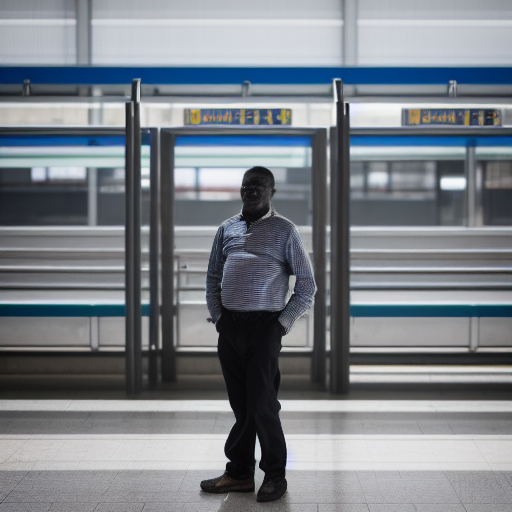

In [15]:
# generate image 
output = pipe(gpt_prompt, gpt_pose_image, negative_prompt=negative_prompt, num_inference_steps=20)
image = output.images[0]
image